###  CORTX Metrics Graphs 

This jupyter notebook creates a few custom interesting graphs and then just does a bulk conversion of every single metric into a graph.

In [1]:
%cd /home/johnbent/cortx/metrics
import os
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import cortx_community
import cortx_graphing
import datetime

%matplotlib inline
ps=cortx_community.PersistentStats()

/home/johnbent/cortx/metrics


In [21]:
# we currently have a bad scrape in the pickle (i.e. '2020-12-20'); instead of removing it just hide it here
def remove_date(df,date):
    try:
        df=df.drop(pd.to_datetime(date),axis=0) # this first scrape was no good, double counted issues and pulls
    except KeyError:
        pass # was already dropped
    return df

In [3]:
# turn a repo (e.g. 'cortx-s3server') into a dataframe suitable for plotting
def get_dataframe(repo,ps):
    return cortx_graphing.get_dataframe(repo,ps)

In [4]:
# using a dataframe, create a plot of just a subset of its columns
def compare_values(repo,ps,targets):
    df=get_dataframe(repo,ps)
    df[targets].plot(title="Repo %s" % repo)

In [5]:
# a function that makes a graph showing the count for all repos for a particular field
# note that it explicitly filters 'GlOBAL' out
def compare_repos(target,ps):
    repos=ps.get_repos()
    dates=ps.get_dates('cortx') # use the dates as 'strings' to pull values from cortx pickles
    data={}
    for repo in repos:
        values = ps.get_values_as_numbers(repo,target,dates)
        if 'ave_age_in_s' in target:
            values=[None if v is None else v/86400 for v in values]
            target=target.replace('ave_age_in_s','ave_age_in_days')
        if repo != 'GLOBAL':
            data[repo]=values
        else:
            data['TOTAL']=values
    dates=[pd.to_datetime(date) for date in dates] # convert the date strings to datetimes for better plotting
    df=pd.DataFrame(data=data, index=dates)
    #df=remove_date(df,'2020-12-20')
    #print(df)
    df.plot(title=target)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [6]:
# adds some new columns to the dataframe doing math on the other and then plots them
def compare_merge_rates(repo,ps):
    df = get_dataframe(repo,ps)
    # make some new columns on the basis of the existing columns
    for k in ['external','internal']:
        df['%s_merge_rate' % k] = df['pull_requests_%s_merged' % k] / df['pull_requests_%s' % k]
    # plot just a few of the columns (the newly created ones)
    df[['external_merge_rate','internal_merge_rate']].plot(ylim=(0,1),title="Merge Rates for %s" % repo)

In [7]:
# for every field in the metrics, make a graph comparing the repos
def make_all_graphs_comparing_repos(ps):
    (latest,date)=ps.get_latest('cortx')
    for k in sorted(latest.keys()):
        compare_repos(k,ps)

The below graph merely shows total pull requests, and internal pull requests, and external pull requests.

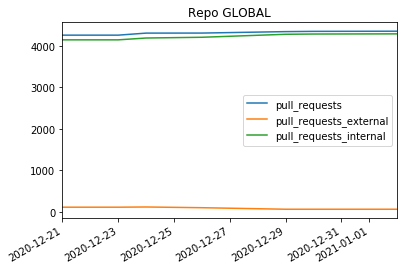

In [9]:
compare_values('GLOBAL',ps,['pull_requests','pull_requests_external','pull_requests_internal'])

The below graph sums 'pull_requests_external' and 'issues_external' across all repos and measures that value against our target goal.

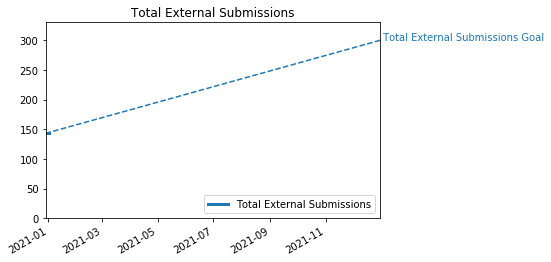

In [28]:
df=get_dataframe('GLOBAL',ps)
title='Total External Submissions'
df[title] = df['pull_requests_external'] + df['issues_external']
df=remove_date(df,'2020-12-21')
df=remove_date(df,'2020-12-22')
df=remove_date(df,'2020-12-23')
df=remove_date(df,'2020-12-24')
df=remove_date(df,'2020-12-26')
goal_date=datetime.datetime(2021,12,31,0,0,0)
xlim=(None,goal_date)
goal=cortx_graphing.Goal(title,goal_date,300)
plt=cortx_graphing.goal_graph(df=df,title=title,xlim=xlim,goals=[goal],columns=[title])
plt.show()

The below graph shows the percentage of submissions (both issues and pull requests) which are external along with a goal.

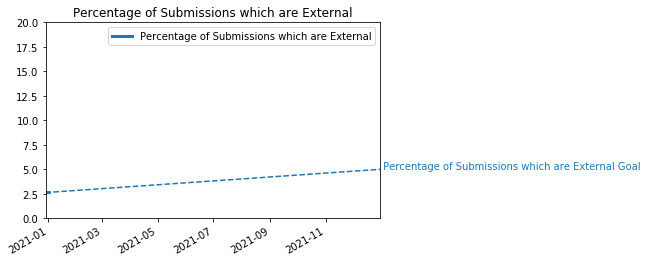

In [27]:
df=get_dataframe('GLOBAL',ps)
title='Percentage of Submissions which are External'
df['total'] = df['pull_requests'] + df['issues']
df['external'] = df['pull_requests_external'] + df['issues_external']
df[title]=(df['external']/df['total'])*100
df=remove_date(df,'2020-12-21')
df=remove_date(df,'2020-12-22')
df=remove_date(df,'2020-12-23')
df=remove_date(df,'2020-12-24')
df=remove_date(df,'2020-12-26')
goal_date=datetime.datetime(2021,12,31,0,0,0)
xlim=(None,goal_date)
goal=cortx_graphing.Goal(title,goal_date,5)
plt=cortx_graphing.goal_graph(df=df,title=title,xlim=xlim,goals=[goal],columns=[title],ylim=(0,20))
plt.legend(loc='upper right')
plt.show()

The following graph is merely comparing the average age of pull requests in the main parent repo for pull requests submitted by internal versus by external folks.

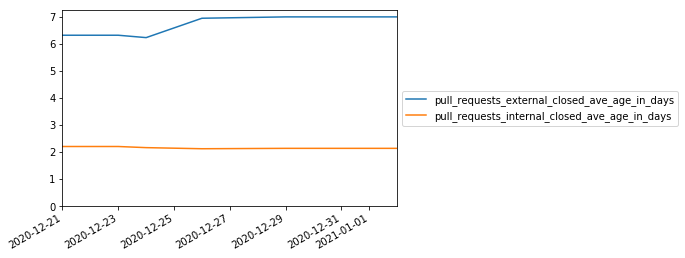

In [11]:
df=get_dataframe('cortx',ps)
columns=[]
for label, content in df.items():
    if 'ave_age_in_days' in label and 'pull' in label and ('external' in label or 'internal' in label) and 'closed' in label:
        columns.append(label)
df[columns].plot(ylim=(0,None))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

The following graphs show every single value that we have in our scraped metrics for all repos as well as for the summed TOTAL.

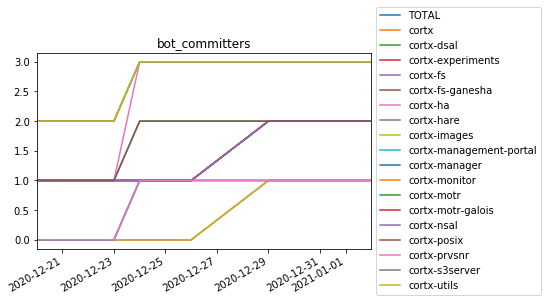

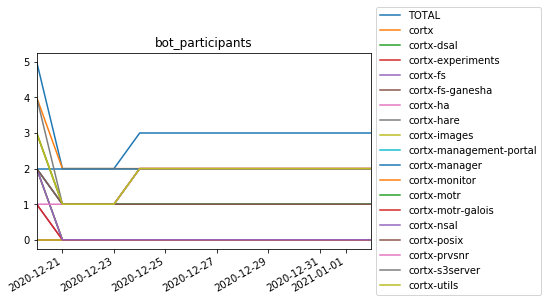

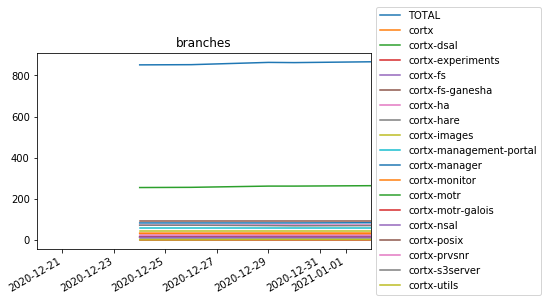

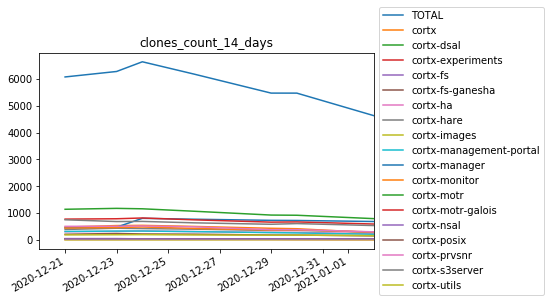

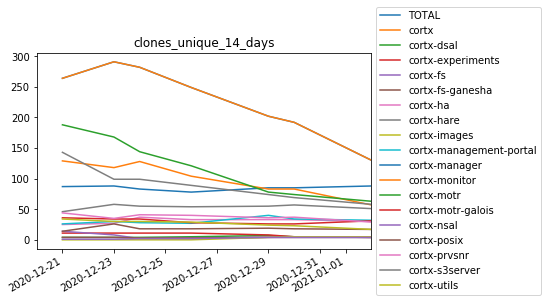

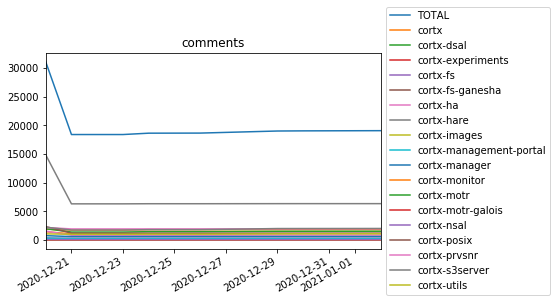

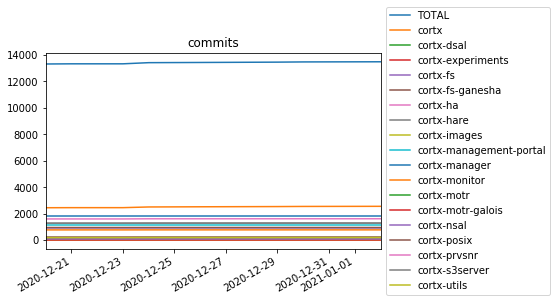

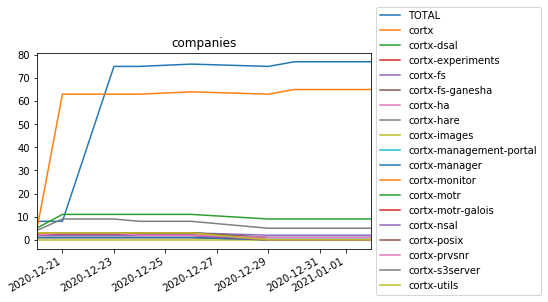

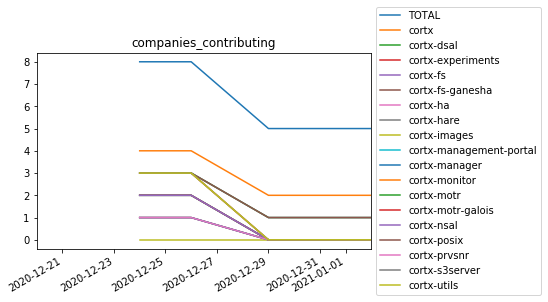

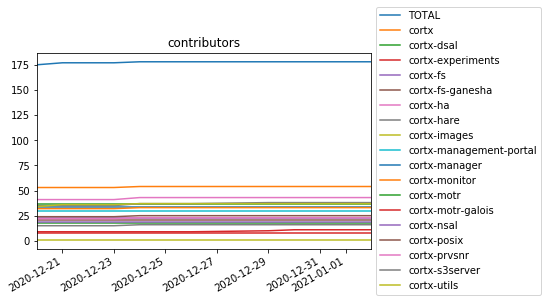

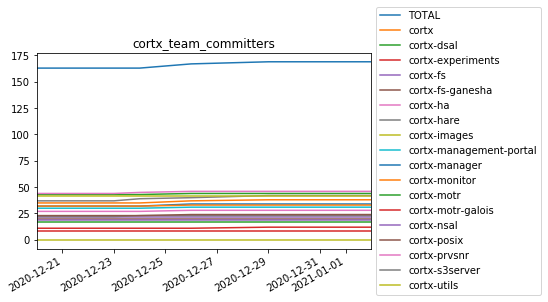

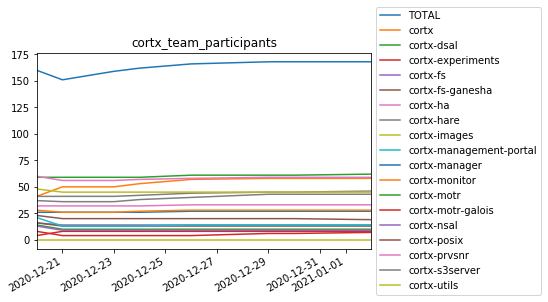

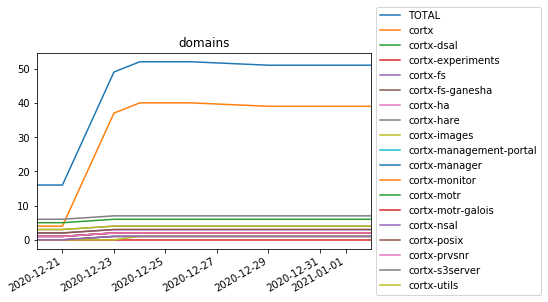

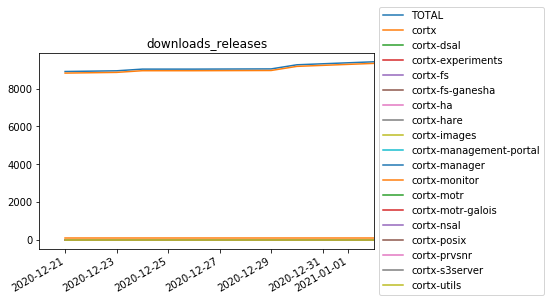

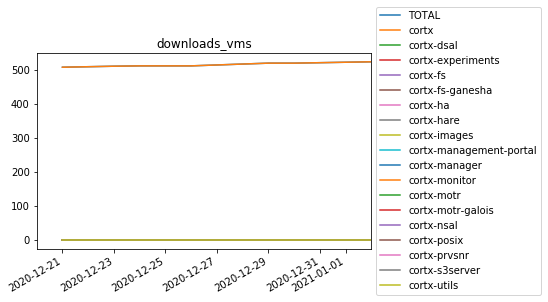

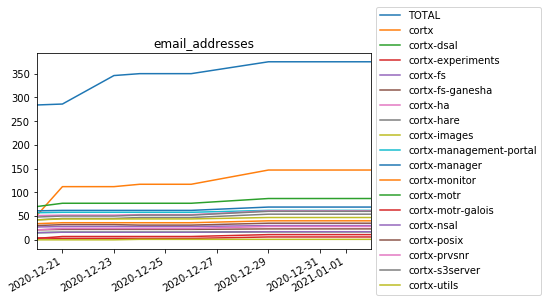

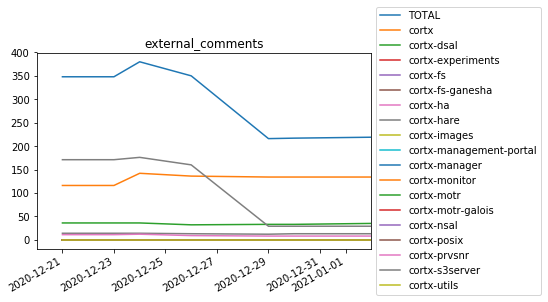

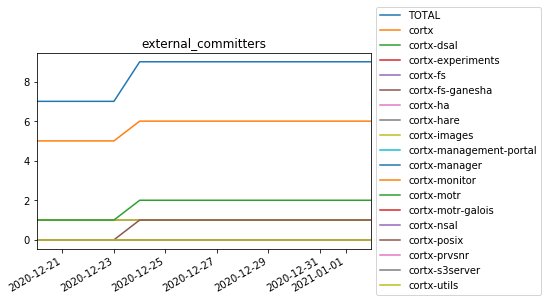

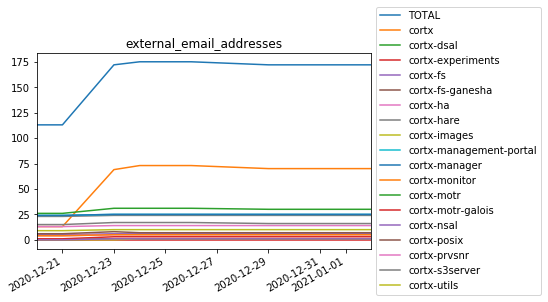

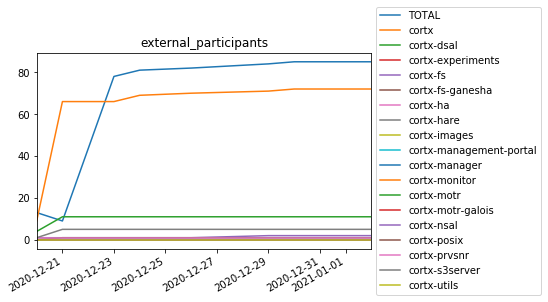

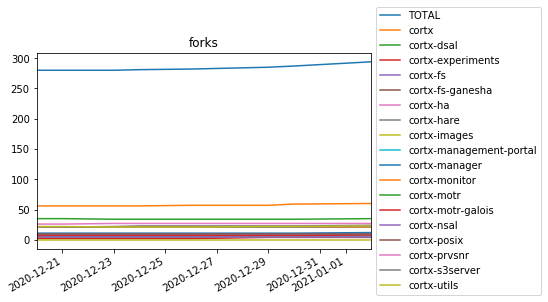

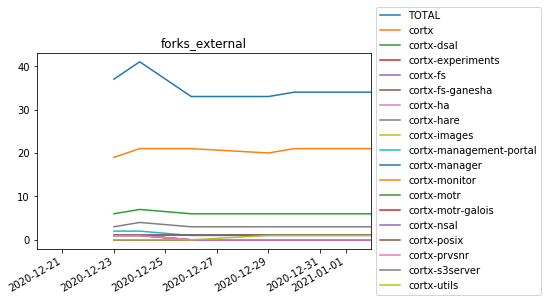

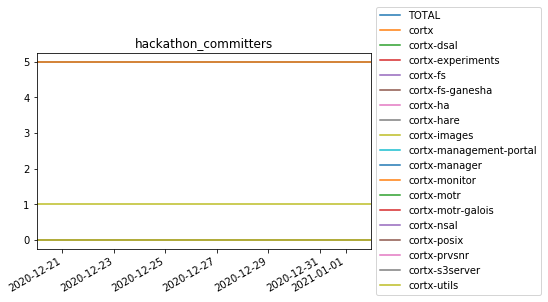

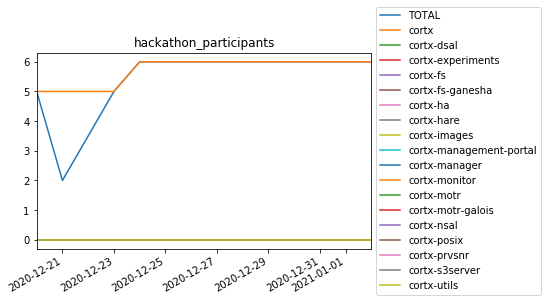

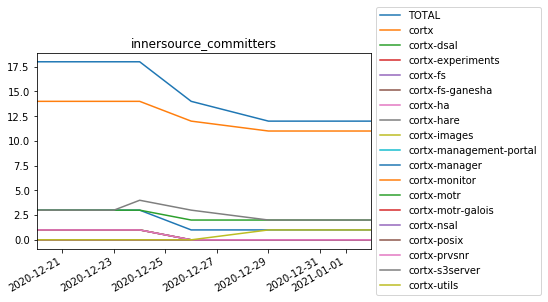

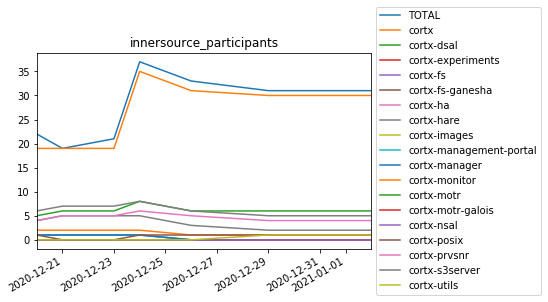

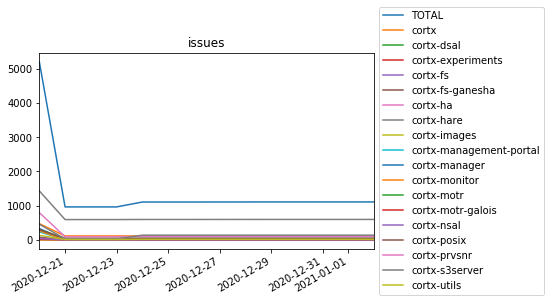

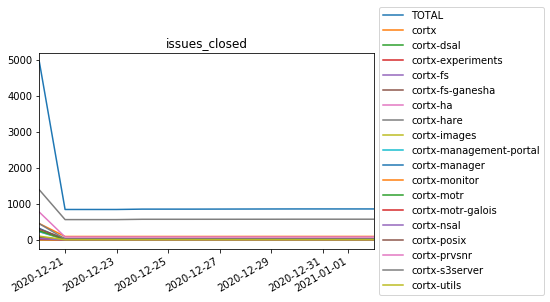

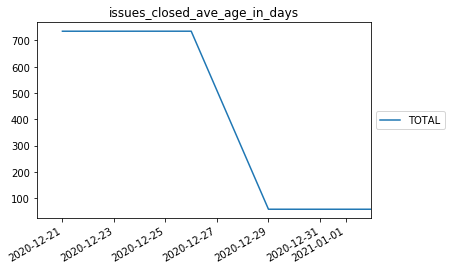

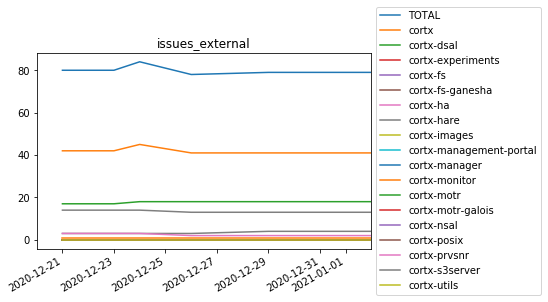

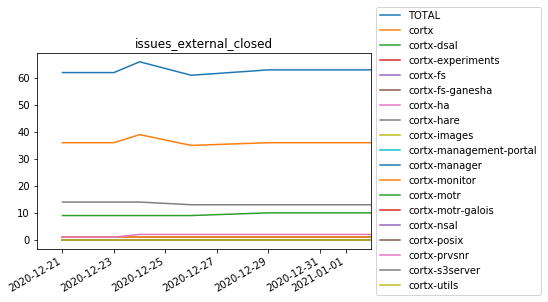

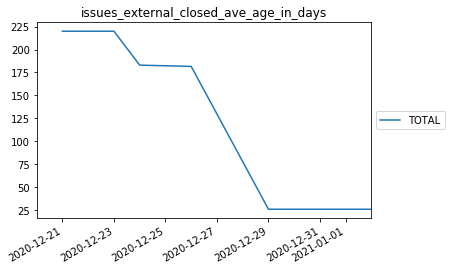

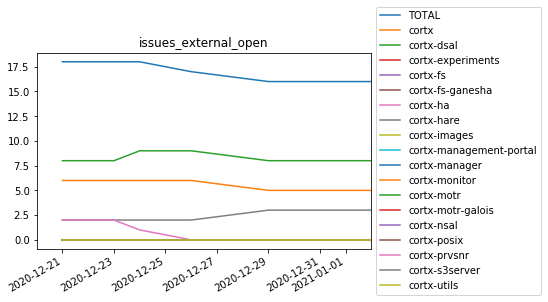

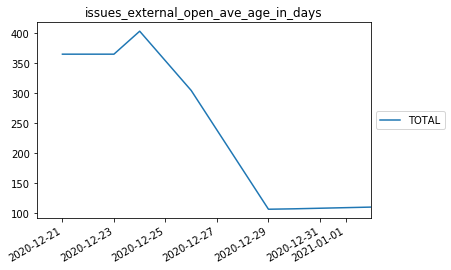

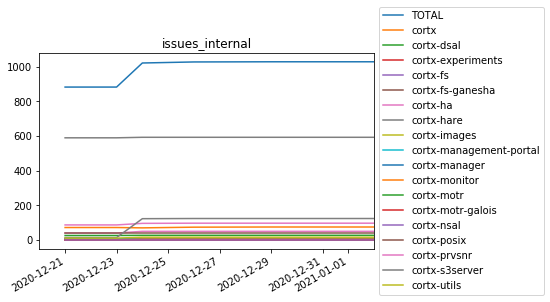

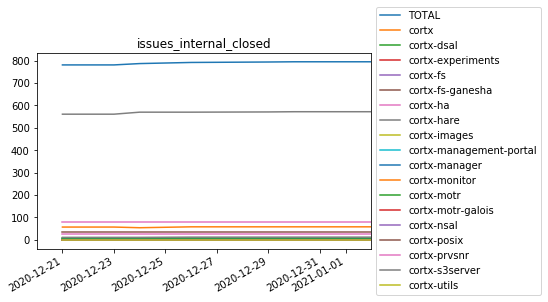

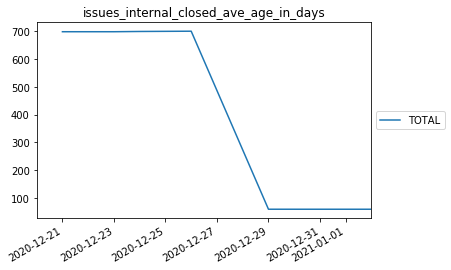

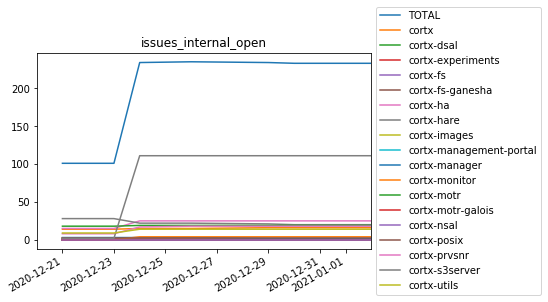

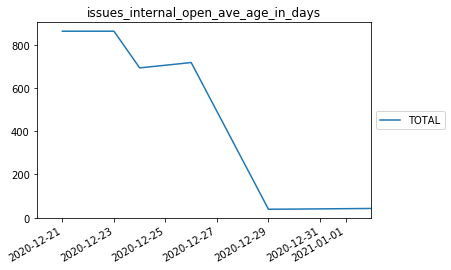

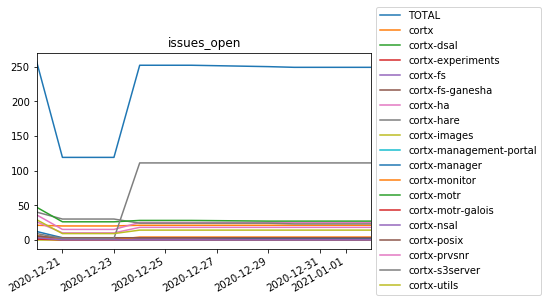

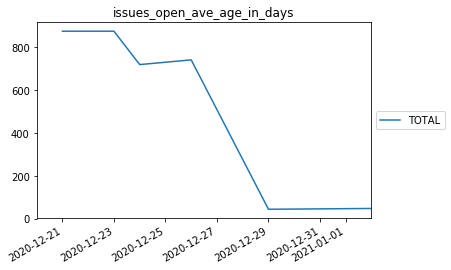

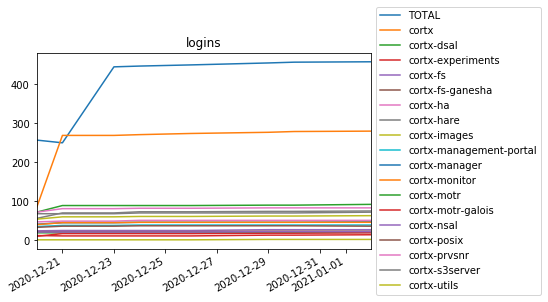

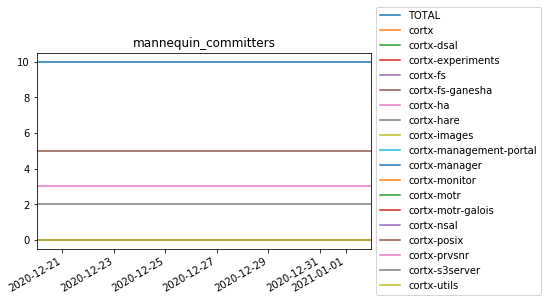

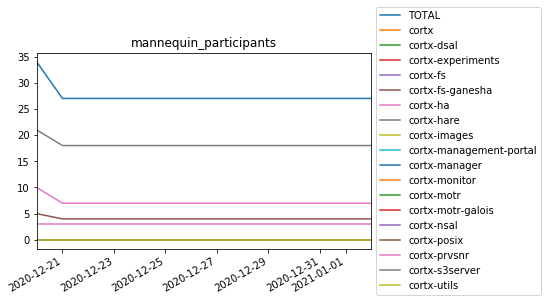

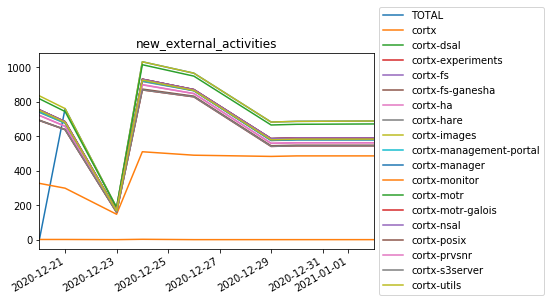

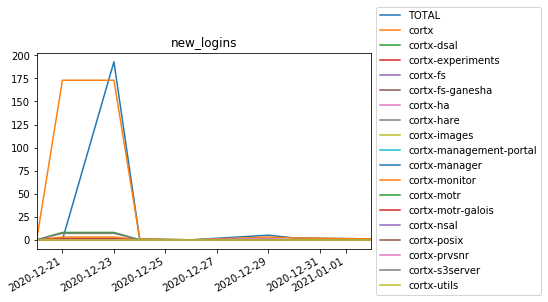

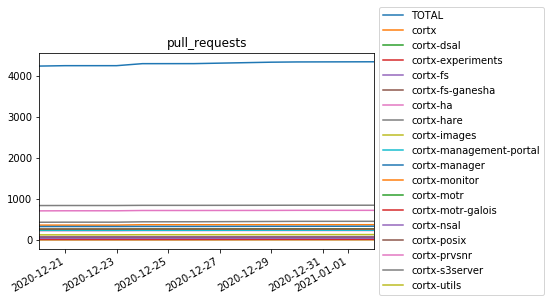

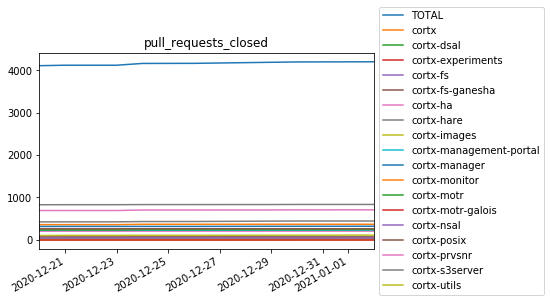

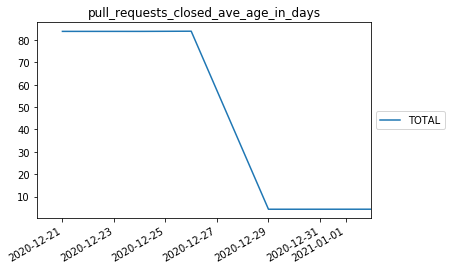

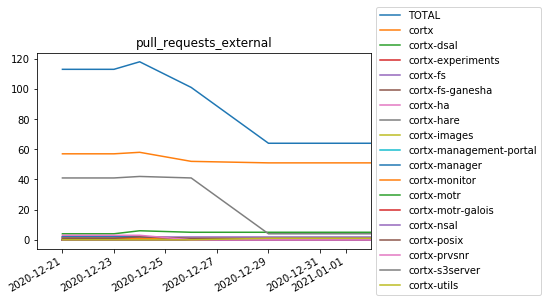

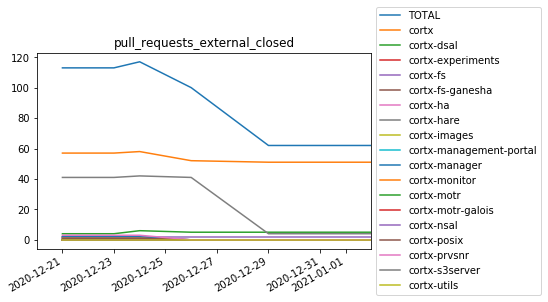

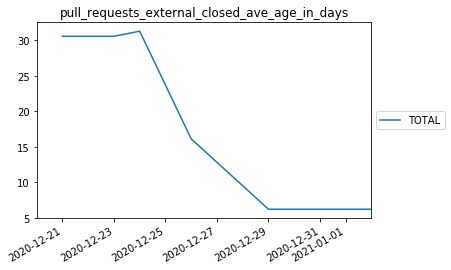

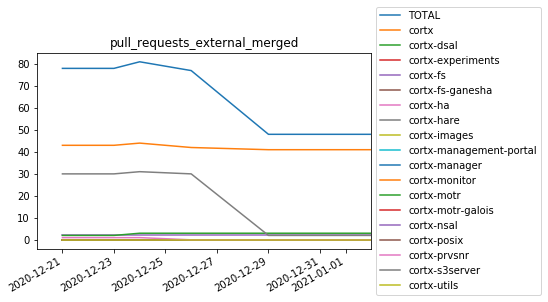

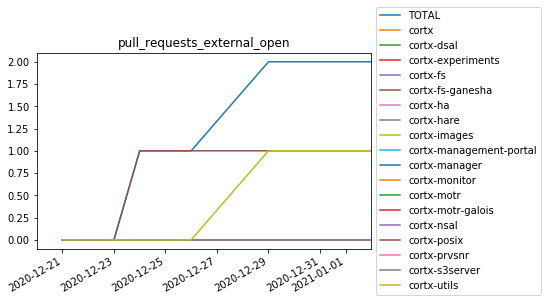

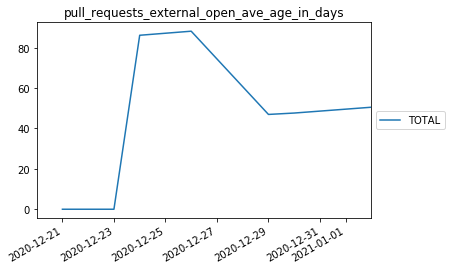

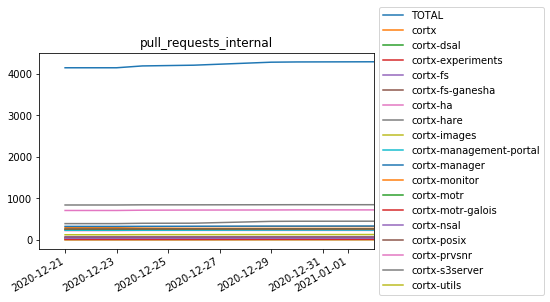

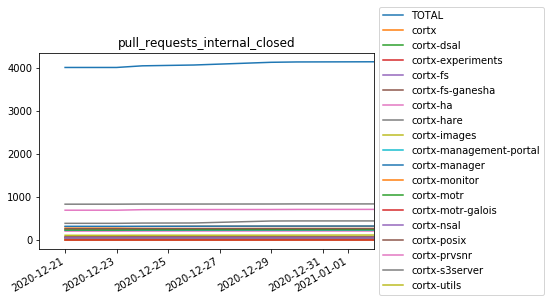

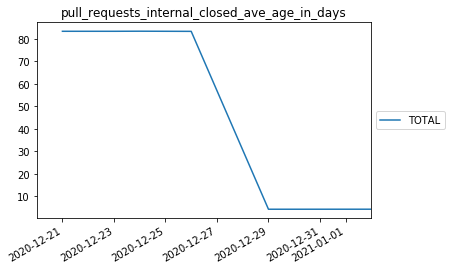

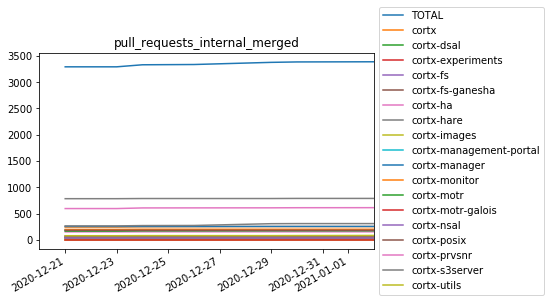

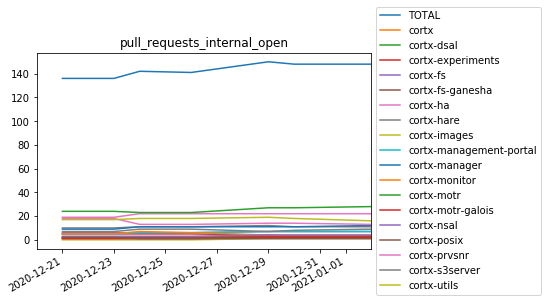

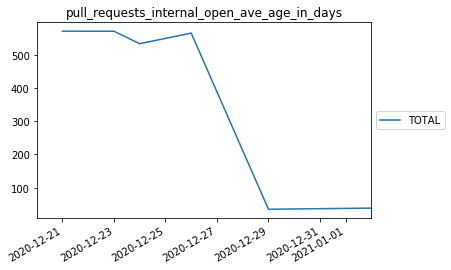

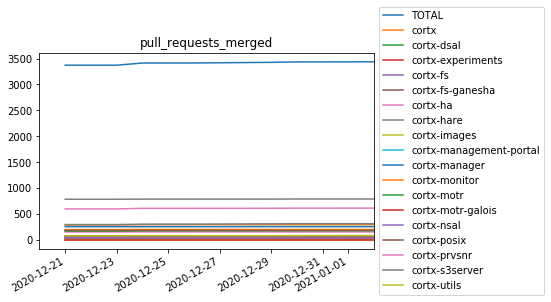

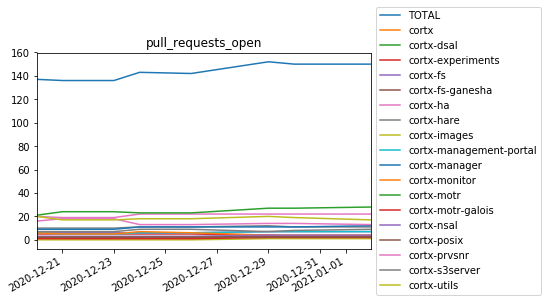

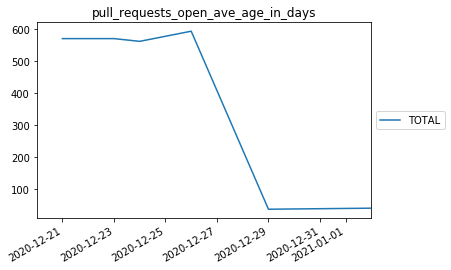

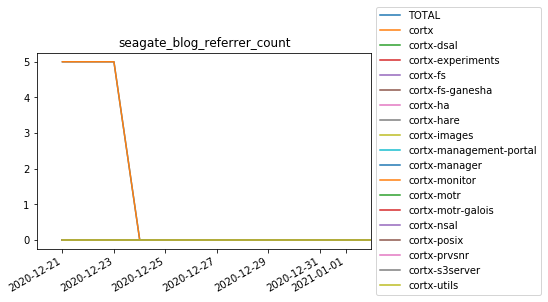

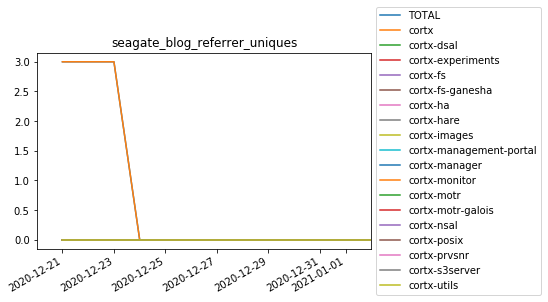

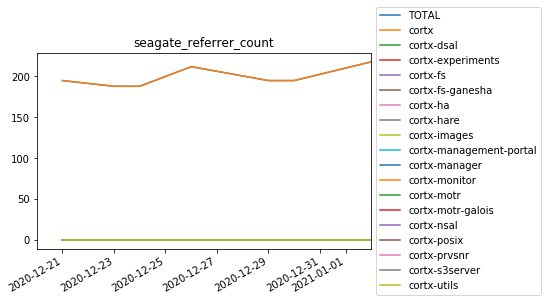

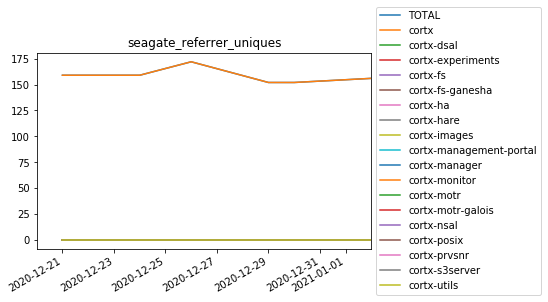

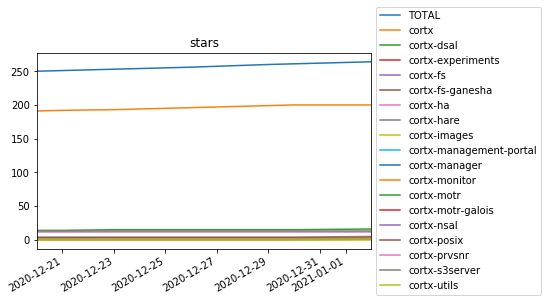

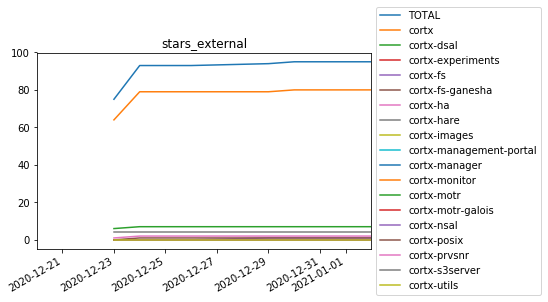

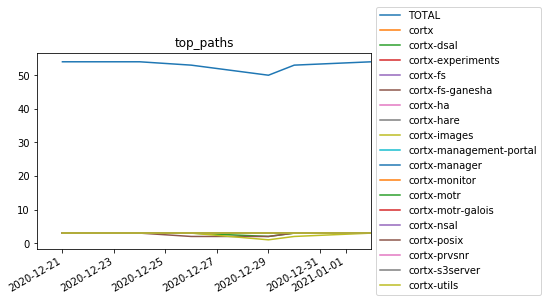

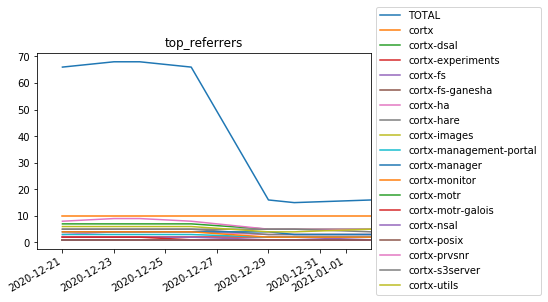

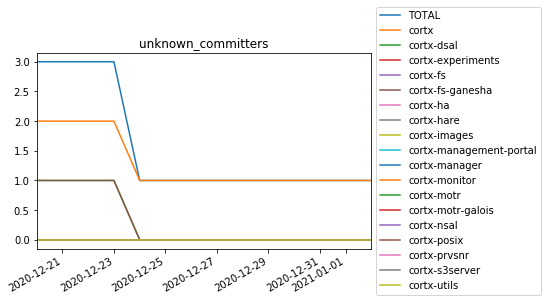

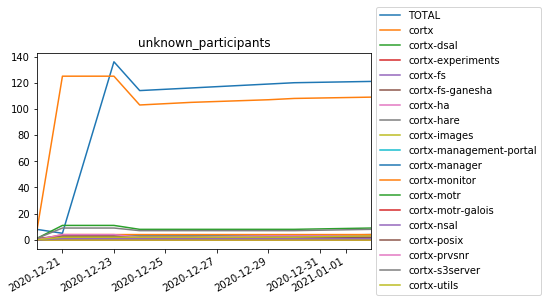

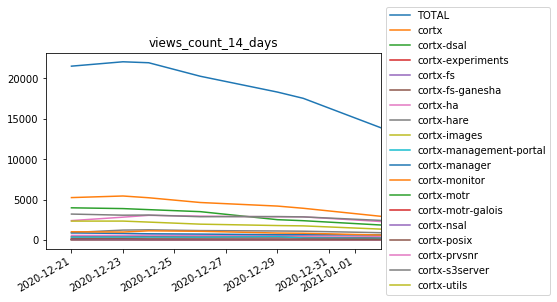

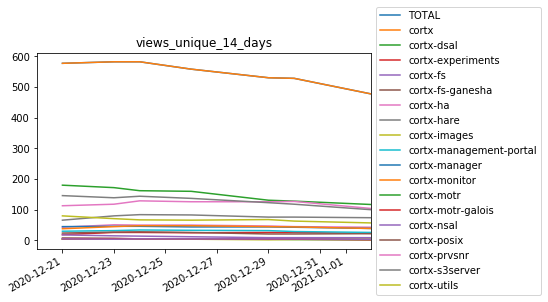

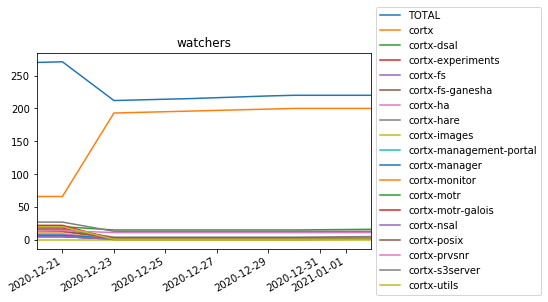

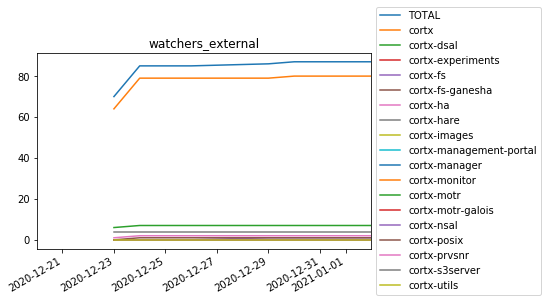

In [12]:
make_all_graphs_comparing_repos(ps)